In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
%cd /content/drive/MyDrive/Github/ml-blog

/content/drive/MyDrive/Github/ml-blog


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report

## Import Scaled Data

In [3]:
filename = 'taiwan-credit-col-transform-FULL.csv'

In [4]:
DATA = os.path.relpath('/content/drive/MyDrive/Github/ml-blog/credit/data/' + filename)

df = pd.read_csv(DATA, index_col='ID', header=0)
df.head()

,category__SEX_1,category__SEX_2,category__EDUCATION_0,category__EDUCATION_1,category__EDUCATION_2,category__EDUCATION_3,category__EDUCATION_4,category__EDUCATION_5,category__EDUCATION_6,category__MARRIAGE_0,...,nums__BILL_AMT4,nums__BILL_AMT5,nums__BILL_AMT6,nums__PAY_AMT1,nums__PAY_AMT2,nums__PAY_AMT3,nums__PAY_AMT4,nums__PAY_AMT5,nums__PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0


In [5]:
X = df.iloc[:, :91]
y = df.iloc[:, 91]
X.columns, y.name, y.shape

(Index(['category__SEX_1', 'category__SEX_2', 'category__EDUCATION_0',
        'category__EDUCATION_1', 'category__EDUCATION_2',
        'category__EDUCATION_3', 'category__EDUCATION_4',
        'category__EDUCATION_5', 'category__EDUCATION_6',
        'category__MARRIAGE_0', 'category__MARRIAGE_1', 'category__MARRIAGE_2',
        'category__MARRIAGE_3', 'category__PAY_0_-2', 'category__PAY_0_-1',
        'category__PAY_0_0', 'category__PAY_0_1', 'category__PAY_0_2',
        'category__PAY_0_3', 'category__PAY_0_4', 'category__PAY_0_5',
        'category__PAY_0_6', 'category__PAY_0_7', 'category__PAY_0_8',
        'category__PAY_2_-2', 'category__PAY_2_-1', 'category__PAY_2_0',
        'category__PAY_2_1', 'category__PAY_2_2', 'category__PAY_2_3',
        'category__PAY_2_4', 'category__PAY_2_5', 'category__PAY_2_6',
        'category__PAY_2_7', 'category__PAY_2_8', 'category__PAY_3_-2',
        'category__PAY_3_-1', 'category__PAY_3_0', 'category__PAY_3_1',
        'category__PAY_3_2'

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression Baseline

In [7]:
lr_base_clf = LogisticRegression(penalty='l2', tol=0.0001, 
                             C=1, solver='lbfgs', 
                             max_iter=500, multi_class='ovr').fit(X_train, y_train)

In [8]:
y_lrbase_preds = lr_base_clf.predict(X_test)

In [9]:
print(confusion_matrix(y_test, y_lrbase_preds))

[[4461  226]
 [ 861  452]]


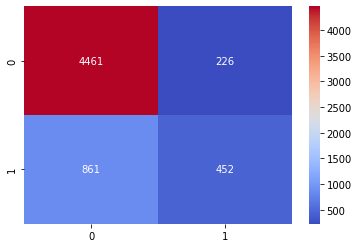

In [10]:
sns.heatmap(confusion_matrix(y_test, y_lrbase_preds), cmap='coolwarm', annot=True, fmt='g')

In [11]:
print(classification_report(y_test, y_lrbase_preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.34      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000



It's about what we expected....


## GridSearchCV to compare hyperparameter settings

In [11]:
lr_param_grid = [
    {'penalty': ['l2'], 'C': [0.1, 1.0, 5.0, 10.0, 100.0], 'tol': [0.001, 0.01, 0.5, 1.0]},
    {'penalty': ['l1'], 'C': [0.1, 1.0, 5.0, 10.0, 100.0], 'tol': [0.001, 0.01, 0.5, 1.0]},
    {'penalty': ['none'], 'tol': [0.001, 0.01, 0.5, 1.0]},
]

xgb_param_grid = [
    {'max_depth': [2], 'n_estimators': [25, 50, 100, 500], 'learning_rate': [0.01, 0.05, 0.075, 0.1]},
    {'max_depth': [4], 'n_estimators': [25, 50, 100, 500], 'learning_rate': [0.01, 0.05, 0.075, 0.1]},
    {'max_depth': [6], 'n_estimators': [25, 50, 100, 500], 'learning_rate': [0.01, 0.05, 0.075, 0.1]},
]

lr = LogisticRegression(max_iter=2000, solver='saga')

xgb = XGBClassifier(use_label_encoder=False)


In [8]:
lr_clf = GridSearchCV(lr, param_grid=lr_param_grid, scoring='roc_auc')
lr_clf.fit(X_train, y_train)


GridSearchCV(estimator=LogisticRegression(max_iter=2000, solver='saga'),
             param_grid=[{'C': [0.1, 1.0, 5.0, 10.0, 100.0], 'penalty': ['l2'],
                          'tol': [0.001, 0.01, 0.5, 1.0]},
                         {'C': [0.1, 1.0, 5.0, 10.0, 100.0], 'penalty': ['l1'],
                          'tol': [0.001, 0.01, 0.5, 1.0]},
                         {'penalty': ['none'], 'tol': [0.001, 0.01, 0.5, 1.0]}],
             scoring='roc_auc')

In [14]:
print(lr_clf.best_params_, lr_clf.best_estimator_, round(lr_clf.best_score_, 3))

{'C': 0.1, 'penalty': 'l2', 'tol': 0.001} LogisticRegression(C=0.1, max_iter=2000, solver='saga', tol=0.001) 0.768


In [12]:
xgb_clf = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='roc_auc')
xgb_clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(use_label_encoder=False),
             param_grid=[{'learning_rate': [0.01, 0.05, 0.075, 0.1],
                          'max_depth': [2],
                          'n_estimators': [25, 50, 100, 500]},
                         {'learning_rate': [0.01, 0.05, 0.075, 0.1],
                          'max_depth': [4],
                          'n_estimators': [25, 50, 100, 500]},
                         {'learning_rate': [0.01, 0.05, 0.075, 0.1],
                          'max_depth': [6],
                          'n_estimators': [25, 50, 100, 500]}],
             scoring='roc_auc')

In [13]:
print(xgb_clf.best_params_, xgb_clf.best_estimator_, round(xgb_clf.best_score_, 3))

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100} XGBClassifier(learning_rate=0.05, max_depth=6, use_label_encoder=False) 0.783


## Evaluation, Graphs, etc.

In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [16]:
y_lr_probas = lr_clf.predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 0 for 'No default'.

In [17]:
y_test_np = y_test.to_numpy()

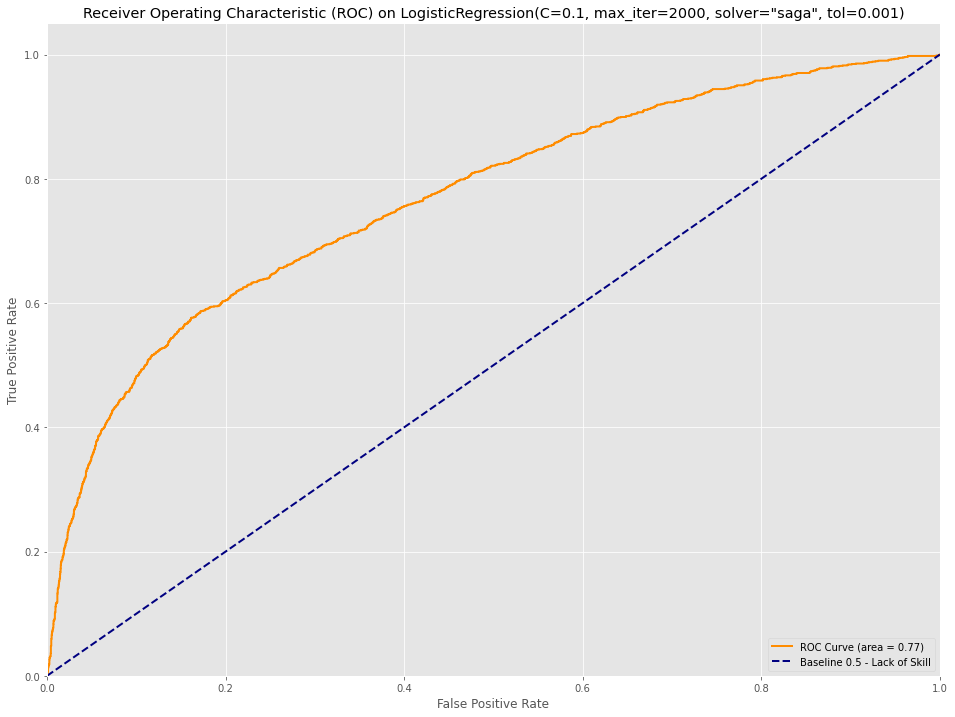

In [18]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_test_np, y_lr_probas)
roc_auc = auc(falsePR, truePR)

plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.2f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on LogisticRegression(C=0.1, max_iter=2000, solver="saga", tol=0.001)')
plt.legend(loc='lower right')
plt.savefig('./credit/model/best-lr-model-auc.png')
plt.show()

In [19]:
y_xgb_probas = xgb_clf.predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 0 for 'No default'.

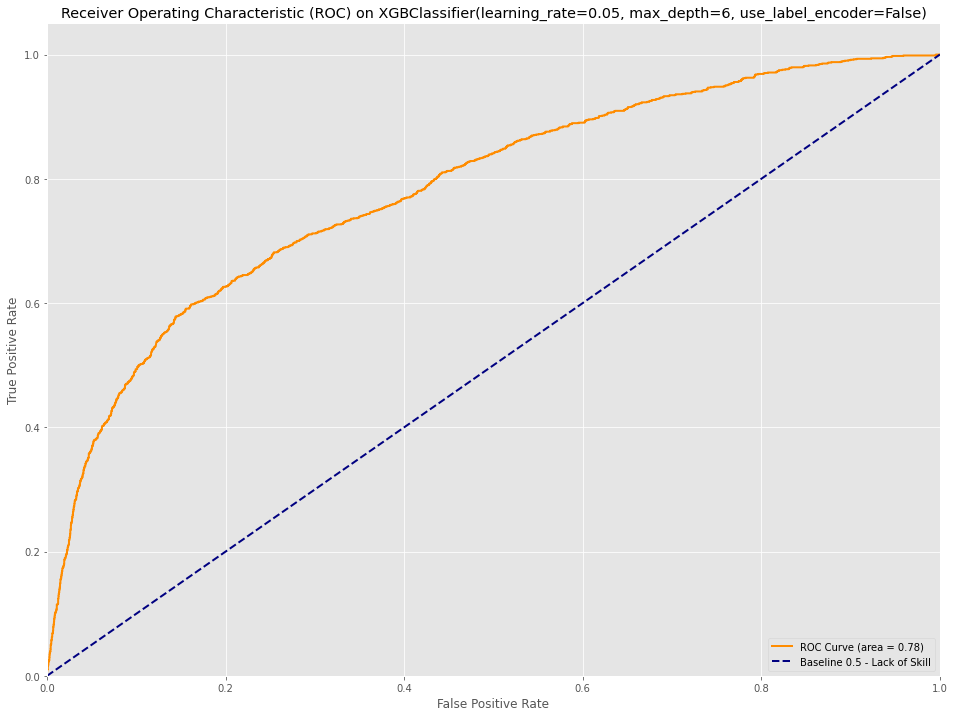

In [20]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_test_np, y_xgb_probas)
roc_auc = auc(falsePR, truePR)

plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.2f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on XGBClassifier(learning_rate=0.05, max_depth=6, use_label_encoder=False)')
plt.legend(loc='lower right')
plt.savefig('./credit/model/best-xgb-model-auc.png')
plt.show()

In [21]:
y_lr_preds = lr_clf.predict(X_test)
y_xgb_preds = xgb_clf.predict(X_test)

In [23]:
print(classification_report(y_test_np, y_lr_preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.66      0.35      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000



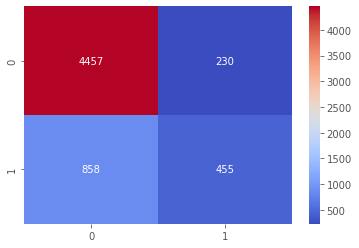

In [25]:
sns.heatmap(confusion_matrix(y_test, y_lr_preds), cmap='coolwarm', annot=True, fmt='g')

In [24]:
print(classification_report(y_test_np, y_xgb_preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.68      0.35      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.81      0.82      0.80      6000



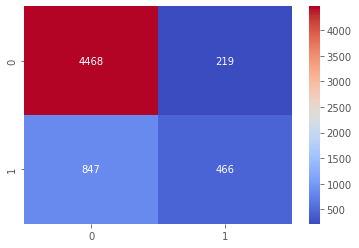

In [26]:
sns.heatmap(confusion_matrix(y_test, y_xgb_preds), cmap='coolwarm', annot=True, fmt='g')